# Nuclear War: Analysis of Twitter's Sentiments

## 1. Background

Threats of a nuclear war are at an all time high.


## 2. Data Collection

In [2]:
#Import the required libraries

import tweepy
import pandas as pd
import numpy as np
from collections import Counter
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import csv
import nltk
nltk.download()
from nltk import WordNetLemmatizer
import string
from emot.emo_unicode import UNICODE_EMOJI
from nltk import word_tokenize

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [3]:
#Store developer credentials
login = pd.read_csv('Login.csv')
#login.shape

In [4]:
#Load Twitter API credentials

consumerKey = login.iloc[0,0]
consumerKeySecret = login.iloc[0,1]
accessToken = login.iloc[0,2]
accessTokenSecret = login.iloc[0,3]

In [5]:
#Authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerKeySecret)

#Set access token and secret
authenticate.set_access_token(accessToken, accessTokenSecret)

#Api object using the keys
api = tweepy.API(authenticate, wait_on_rate_limit = True)
sleep_on_rate_limit = False

In [6]:
def getTweets(searchString, numOfTweets):
    tweetsList = [tweets for tweets in tweepy.Cursor(api.search_tweets, q =searchString, lang='en', tweet_mode='extended').items(numOfTweets)]
    for tweet in tweetsList:
        tweet_id = tweet.id
        created_at = tweet.created_at
        content = tweet.full_text
        location = tweet.user.location
        retweet = tweet.retweet_count
        favorite = tweet.favorite_count
        with open('nuclear.csv', 'a', newline='', encoding='utf-8') as csvFile:
            csvWriter = csv.writer(csvFile, delimiter = ',')
            csvWriter.writerow([tweet_id, created_at, content, location, retweet, favorite])
    

In [147]:
#Search for tweets with specific keywords
searchString = "Nuclear War OR #nuclearwar OR #NuclearWar OR World War 3 OR #Russia OR #NATO OR #Putin OR #Zelensky OR #Armageddon OR #WW3 OR #russia OR #war OR #War OR #nuclear -filter:retweets AND -filter:replies"

getTweets(searchString, 10000)

Rate limit reached. Sleeping for: 585


In [7]:
#Store csv file in a dataframe and rename columns

df_tweets = pd.read_csv('nuclear.csv', index_col = None, header= None, encoding='utf-8')
df_tweets.head()

,0,1,2,3,4,5
0,1579237425716793345,2022-10-09 22:28:37+00:00,Do you believe we are soon facing a nuclear wa...,Mother Earth 🌎 ❤,0,0
1,1579236115059351553,2022-10-09 22:23:25+00:00,".@NATO \n\nMAKE NO MISTAKE... together, we wil...",Boston,0,0
2,1579233283266650113,2022-10-09 22:12:10+00:00,Probability of nuclear war is rising because m...,"Durban,South Africa",0,0
3,1579231075091742721,2022-10-09 22:03:23+00:00,"Russia buying $86,000 of sodium iodide tablets...",NaN,0,0
4,1579230857348673536,2022-10-09 22:02:31+00:00,Choose 3 of my policies\n\n1. Ban homosexualit...,NaN,1,6


In [8]:
df_tweets.rename(columns={0: 'ID',1: 'Tweet_Time',2: 'Content',3:'Location',4:'Retweets',5:'Likes'},inplace = True)

## 3. Data Cleaning and Preprocessing


In [9]:
#Check dupliate values
df_tweets.duplicated(subset=['ID']).sum()

0

In [10]:
df_tweets.shape

(2368, 6)

In [11]:
#location has some null values
df_tweets.isna().sum()

ID              0
Tweet_Time      0
Content         0
Location      708
Retweets        0
Likes           0
dtype: int64

In [12]:
df_tweets['Location'] = df_tweets['Location'].fillna('No Location')
df_tweets.isna().sum()

ID            0
Tweet_Time    0
Content       0
Location      0
Retweets      0
Likes         0
dtype: int64

In [13]:
#Get hashtags for analysis by removing #
def getHashtags(tweet):
    tweet = tweet.lower()
    tweet = re.findall(r'\#\w+',tweet)
    return " ".join(tweet)

df_tweets['Hashtags'] = df_tweets['Content'].apply(getHashtags)
df_tweets.head()

,ID,Tweet_Time,Content,Location,Retweets,Likes,Hashtags
0,1579237425716793345,2022-10-09 22:28:37+00:00,Do you believe we are soon facing a nuclear wa...,Mother Earth 🌎 ❤,0,0,#atomicbomb #putin #russia #ukraine #ukraina #...
1,1579236115059351553,2022-10-09 22:23:25+00:00,".@NATO \n\nMAKE NO MISTAKE... together, we wil...",Boston,0,0,#388magictweets #nato #ukraine
2,1579233283266650113,2022-10-09 22:12:10+00:00,Probability of nuclear war is rising because m...,"Durban,South Africa",0,0,#humans #russianukrainianwar #men #russiaisate...
3,1579231075091742721,2022-10-09 22:03:23+00:00,"Russia buying $86,000 of sodium iodide tablets...",No Location,0,0,
4,1579230857348673536,2022-10-09 22:02:31+00:00,Choose 3 of my policies\n\n1. Ban homosexualit...,No Location,1,6,


In [14]:
hashtags_list = df_tweets['Hashtags'].tolist()

hashtags_list

['#atomicbomb #putin #russia #ukraine #ukraina #iran #nato #northkorea #southkorea #korea #china #japan #war #nuclearwar #nucleararmageddon #nowar #нетвойнесукраиной #нетвойне #ukrainerussiawar #usa #america #biden',
 '#388magictweets #nato #ukraine',
 '#humans #russianukrainianwar #men #russiaisateroriststate #elonmusk #nato #ukrainerussiawar',
 '',
 '',
 '#ww3',
 '',
 '#nato #usa #ukraine',
 '#biden #nato #ukraine',
 '#ukraine #nuclear #crimeanbridge #ukrainerussiawar',
 '#ukraine #usa #germany #ireland #eu #uk #europe #france #austria #czech #netherlands #poland #lithuania #latvia #estonia #canada #japan #australia #finland #sweden #nato #russiaisaterroriststate',
 '',
 '#nuclearwar #stevequayle #ukraine #nato #russia #nuclearwar #ww3',
 '#nuclear #zaporizhzhia',
 '#nuclear',
 '#catsoftwittter #kitten #russiaislosing #crimeanbridge #armageddon',
 '#climatecrisis #nuclear #war',
 '#mightywordonktn',
 '#popefrancis #nuclear',
 '#putin #nuclear #crimeabridge #zelensky #russians #god #p

In [32]:
#add all hashtags to a list by splitting at whitespace where there are multiple hashtags
hashtags = []
for item in hashtags_list:
    item = item.split()
    for i in item:
        hashtags.append(i)
        
#Determine unique hashtags - returns dictionary
count = Counter(hashtags)
df_hashtags = pd.DataFrame.from_dict(count, orient='index').reset_index()
df_hashtags.columns = ['Hashtags', 'Count']
df_hashtags.sort_values(by='Count', ascending= False, inplace = True)
df_hashtags.head()
df_hashtags.to_csv('hashtags.csv', index=False)

In [16]:
#prepare tweet content for sentiment analysis
emojis = list(UNICODE_EMOJI.keys())
def prepTweet(tweet):
    tweet = tweet.lower()
    # remove weblinks
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags = re.MULTILINE)
    # remove repeating characters
    tweet = re.sub(r'\@\w+|\#\w+|\d+', '', tweet)
    #remove emojis
    tokens = word_tokenize(tweet)
    clean_tweets = [x for x in tokens if x not in emojis]
    #remove punctuation
    clean_tweets = [x for x in clean_tweets if x not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in clean_tweets]
    return " ".join(lemma_words)
    

In [17]:
df_tweets['Clean_Tweets'] = df_tweets['Content'].apply(prepTweet)
df_tweets.head()

,ID,Tweet_Time,Content,Location,Retweets,Likes,Hashtags,Clean_Tweets
0,1579237425716793345,2022-10-09 22:28:37+00:00,Do you believe we are soon facing a nuclear wa...,Mother Earth 🌎 ❤,0,0,#atomicbomb #putin #russia #ukraine #ukraina #...,do you believe we are soon facing a nuclear wa...
1,1579236115059351553,2022-10-09 22:23:25+00:00,".@NATO \n\nMAKE NO MISTAKE... together, we wil...",Boston,0,0,#388magictweets #nato #ukraine,make no mistake ... together we will fight and...
2,1579233283266650113,2022-10-09 22:12:10+00:00,Probability of nuclear war is rising because m...,"Durban,South Africa",0,0,#humans #russianukrainianwar #men #russiaisate...,probability of nuclear war is rising because m...
3,1579231075091742721,2022-10-09 22:03:23+00:00,"Russia buying $86,000 of sodium iodide tablets...",No Location,0,0,,russia buying of sodium iodide tablet seems li...
4,1579230857348673536,2022-10-09 22:02:31+00:00,Choose 3 of my policies\n\n1. Ban homosexualit...,No Location,1,6,,choose of my policy ban homosexuality repeal t...


In [18]:
#String to be used for word cloud
tweets_string = df_tweets['Clean_Tweets'].tolist()
tweets_string = " ".join(tweets_string)


In [22]:
#Get polarity score
def polarityScore(tweet):
    return TextBlob(tweet).sentiment.polarity

#Get sentiment category

def getSentimentCategory(polarity):
    if polarity<0:
        return "Negative"
    elif polarity>0:
        return "Positive"
    else:
        return "Neutral"
    
#get polarity score of cleaned tweets
df_tweets['Polarity_Score'] = df_tweets['Clean_Tweets'].apply(polarityScore)
df_tweets['Sentiment'] = df_tweets['Polarity_Score'].apply(getSentimentCategory)
df_tweets['Sentiment'].value_counts()

Positive    859
Neutral     783
Negative    726
Name: Sentiment, dtype: int64

In [31]:
#Generate word cloud
tweet_wordCloud = WordCloud(collocations = False, max_words=200, background_color = 'white').generate(tweets_string)

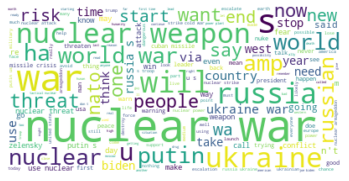

In [30]:
plt.imshow(tweet_wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
#Save data frame to csv to do analysis in tableau
df_tweets.to_csv('nuclearWarTweets.csv', index=False)

tweet_wordCloud.to_file('wordcloud.png')